In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

c:\Users\WINDOWS\Desktop\Bootcamp_IA\Hospital_F5\DS_Grupo3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'DS_Grupo3\\src\\data'
file_name = 'stroke_woe_smote.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df = pd.read_csv(file_path)
df.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,bmi_category,age_category,glucose_level_category,stroke
0,1,0,1,1,0.059265,1,0.559182,0.176297,1.069885,0.921024,1
1,1,0,1,1,0.059265,0,-0.249627,0.176297,1.069885,-0.301429,1
2,0,0,0,1,0.059265,1,0.062398,0.176297,-0.367003,0.921024,1
3,0,1,0,1,0.528860,0,-0.249627,-0.543404,1.069885,0.921024,1
4,1,0,0,1,0.059265,1,0.559182,0.286053,1.069885,0.921024,1


In [3]:
y = df['stroke']
X = df.drop(['stroke'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1337)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [4]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100, log=True),
        'random_state': 42,
        'eval_metric': 'logloss'
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
    
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return sum(accuracies) / len(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

[I 2024-10-14 09:44:03,372] A new study created in memory with name: no-name-e08dbd07-9373-4732-badf-0298c02871e7
[I 2024-10-14 09:44:04,245] Trial 0 finished with value: 0.7423402286309089 and parameters: {'n_estimators': 139, 'learning_rate': 0.05321513402405548, 'max_depth': 5, 'reg_alpha': 0.00532904022250581, 'reg_lambda': 1.0460685245163077}. Best is trial 0 with value: 0.7423402286309089.
[I 2024-10-14 09:44:08,301] Trial 1 finished with value: 0.7470942520964527 and parameters: {'n_estimators': 921, 'learning_rate': 0.28063601027603785, 'max_depth': 10, 'reg_alpha': 0.1562889357272101, 'reg_lambda': 2.7568280499443372e-05}. Best is trial 1 with value: 0.7470942520964527.
[I 2024-10-14 09:44:10,079] Trial 2 finished with value: 0.7460376164951628 and parameters: {'n_estimators': 448, 'learning_rate': 0.16975095586588132, 'max_depth': 5, 'reg_alpha': 0.3855517674344406, 'reg_lambda': 7.408855339695844e-05}. Best is trial 1 with value: 0.7470942520964527.
[I 2024-10-14 09:44:11,94

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05857707536112275,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=972, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [5]:
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

cv_scores = cross_val_score(final_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

Puntajes de validación cruzada: [0.74656811 0.74854728 0.74590597 0.74484945 0.74590597]
Media de los puntajes: 0.7463553546635161


Precisión del modelo: 0.7461267605633802


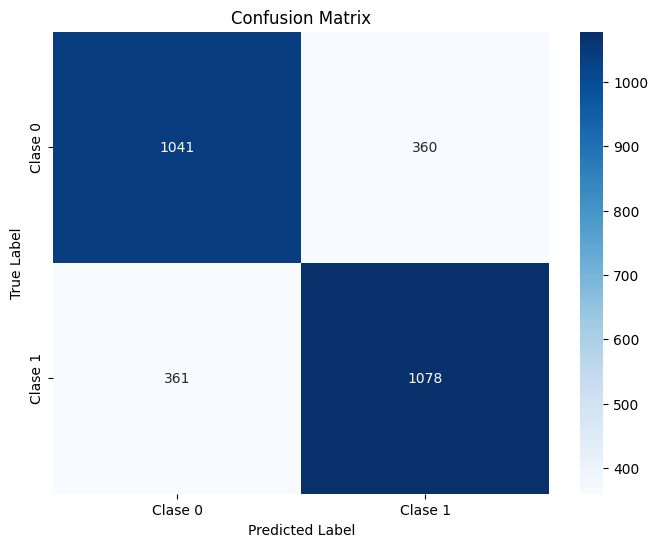

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      1401
           1       0.75      0.75      0.75      1439

    accuracy                           0.75      2840
   macro avg       0.75      0.75      0.75      2840
weighted avg       0.75      0.75      0.75      2840



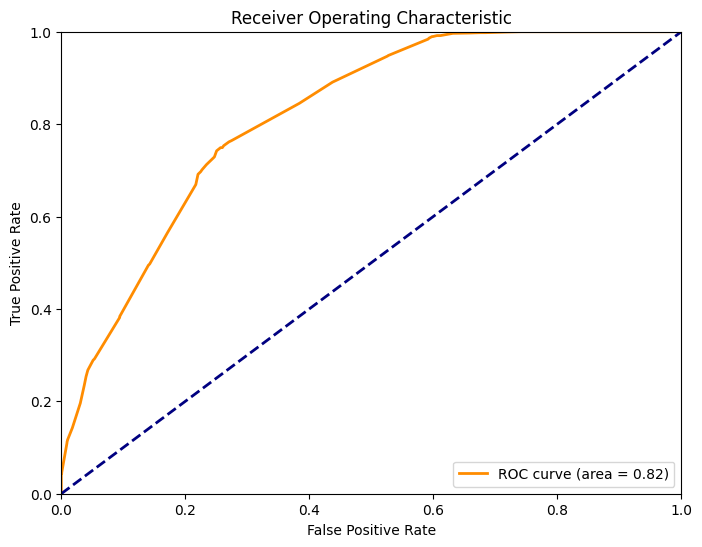

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'DS_Grupo3\\src\\data'
file_name = 'test_stroke_woe.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df_test = pd.read_csv(file_path)

In [9]:
# Separar las características y la variable objetivo del conjunto de test
X_test_new = df_test.drop(['stroke'], axis=1).astype(int)
y_test_new = df_test['stroke']

# Predecir con el modelo final
y_pred_test_new = final_model.predict(X_test_new)
accuracy_test_new = accuracy_score(y_test_new, y_pred_test_new)

# Evaluar el modelo
conf_matrix_test_new = confusion_matrix(y_test_new, y_pred_test_new)
class_report_test_new = classification_report(y_test_new, y_pred_test_new)

# Mostrar resultados
print(f"Precisión del modelo en el conjunto de test: {accuracy_test_new}")
print("Matriz de confusión:\n", conf_matrix_test_new)
print("Reporte de clasificación:\n", class_report_test_new)

Precisión del modelo en el conjunto de test: 0.7352056168505516
Matriz de confusión:
 [[690 253]
 [ 11  43]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.73      0.84       943
           1       0.15      0.80      0.25        54

    accuracy                           0.74       997
   macro avg       0.56      0.76      0.54       997
weighted avg       0.94      0.74      0.81       997



Precisión del modelo: 0.7352056168505516


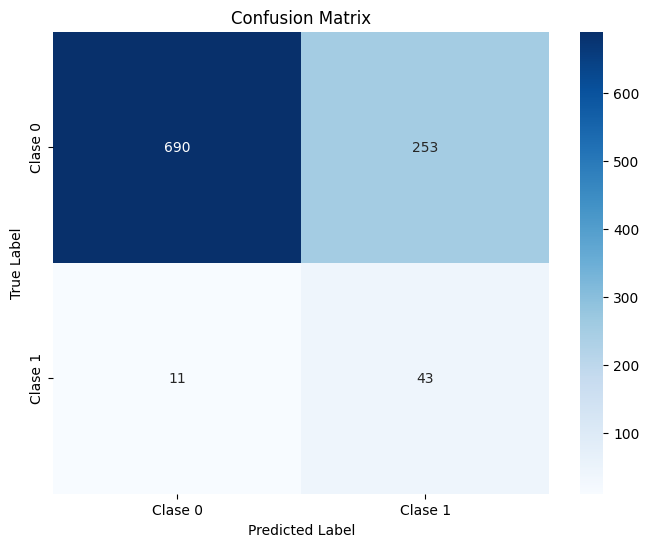

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.73      0.84       943
           1       0.15      0.80      0.25        54

    accuracy                           0.74       997
   macro avg       0.56      0.76      0.54       997
weighted avg       0.94      0.74      0.81       997



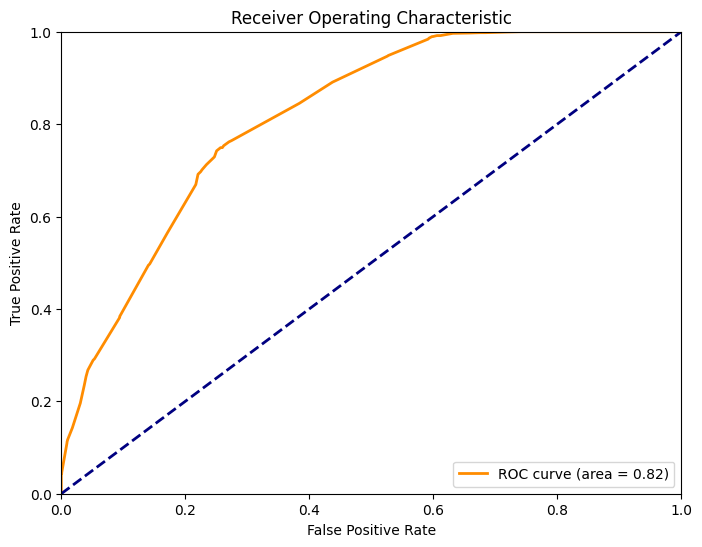

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test_new, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_test_new}")
plt.show()
print("Reporte de clasificación:\n", class_report_test_new)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()